<a href="https://colab.research.google.com/github/davidgoins236/data_viz_final_project/blob/main/data_viz_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Visual History of Formula 1 Racing: An Exploratory Data Analysis

Author: David Goins

Goal: Understand how Formula 1 has evolved over time using historical data with a seconary objective to evaluate which visualizations communicate these trends most effectively.

Data Source: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

In [69]:
!git clone https://github.com/davidgoins236/data_viz_final_project
%cd data_viz_final_project

Cloning into 'data_viz_final_project'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 49 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 7.34 MiB | 4.70 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/data_viz_final_project/data_viz_final_project/data_viz_final_project


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import altair as alt
import matplotlib.ticker as mticker
#required to save ploty charts as static images to view in github
from IPython.display import Image
import plotly.io as pio
alt.renderers.enable('default')  # makes sure PNG is used in static output

RendererRegistry.enable('default')

# Functions:
- For this project I leveraged some custom functions in scenarios where I wanted to explore

In [71]:
def string_lap_time_to_seconds(x):
  # this function is used to convert lap times expressed as a string into seconds
    try:
        minutes, seconds = x.split(':')
        return int(minutes) * 60 + float(seconds)
    except:
        return np.nan

In [72]:
def ms_to_laptime_str(ms):
    """
    Converts milliseconds to a lap time string in the format MM:SS.sss
    """
    if pd.isnull(ms) or ms < 0:
        return None

    minutes = ms // 60000
    seconds = (ms % 60000) / 1000
    return f"{int(minutes)}:{seconds:06.3f}"


# Data Load, Wrangling & Cleaning

In [73]:
circuits = pd.read_csv('circuits.csv')
constructor_results = pd.read_csv('constructor_results.csv')
constructor_standings = pd.read_csv('constructor_standings.csv')
constructors = pd.read_csv('constructors.csv')
driver_standings = pd.read_csv('driver_standings.csv')
drivers = pd.read_csv('drivers.csv')
lap_times = pd.read_csv('lap_times.csv')
pit_stops = pd.read_csv('pit_stops.csv')
quali = pd.read_csv('qualifying.csv')
races = pd.read_csv('races.csv')
results = pd.read_csv('results.csv')
seasons = pd.read_csv('seasons.csv')
sprint = pd.read_csv('sprint_results.csv')
status = pd.read_csv('status.csv')

## Create Combined Results DF

In [74]:
combined_results_df = results.merge(races, how = 'left', on = 'raceId',suffixes=['_result','_race'])\
    .merge(drivers, how = 'left', on = 'driverId',suffixes=['','_driver'])\
    .merge(constructors, how = 'left', on = 'constructorId',suffixes=['','_constructor'])\
    .merge(circuits, how = 'left', on = 'circuitId',suffixes=['','_circuit'])
#fastest lap time from object to second count
combined_results_df['fastestLapTime'] = combined_results_df['fastestLapTime'].apply(string_lap_time_to_seconds)
combined_results_df.describe()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,fastestLapTime,statusId,year,round,circuitId,lat,lng,alt
count,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,8252.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000
mean,13380.977391,551.687283,278.673530,50.180537,11.134796,12.794051,1.987632,46.301768,90.827595,17.224971,1991.394372,8.511192,23.820808,33.949556,5.724416,276.847416
std,7726.134642,313.265036,282.703039,61.551498,7.202860,7.665951,4.351209,29.496557,12.338956,26.026104,19.952885,5.070231,19.112002,25.246080,57.632776,409.086550
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,55.404000,1.000000,1950.000000,1.000000,1.000000,-37.849700,-118.189000,-7.000000
25%,6690.500000,300.000000,57.000000,6.000000,5.000000,6.000000,0.000000,23.000000,80.848250,1.000000,1977.000000,4.000000,9.000000,34.843100,-1.016940,18.000000
50%,13380.000000,531.000000,172.000000,25.000000,11.000000,12.000000,0.000000,53.000000,90.267500,10.000000,1991.000000,8.000000,18.000000,43.734700,6.947500,153.000000
75%,20069.500000,811.000000,399.500000,63.000000,17.000000,18.000000,2.000000,66.000000,99.476750,14.000000,2009.000000,12.000000,34.000000,49.254200,14.764700,401.000000
max,26764.000000,1144.000000,862.000000,215.000000,34.000000,39.000000,50.000000,200.000000,202.300000,141.000000,2024.000000,24.000000,80.000000,57.265300,144.968000,2227.000000


## Create Race Lap Aggregate D F

In [75]:
agg_race_lap_times_df = lap_times.merge(races[['raceId','year','circuitId']])\
  .merge(circuits[['circuitId','name']], how = 'left', on = 'circuitId')\
  .groupby(['year','name']).agg(
      fastest_lap_ms = ('milliseconds','min'),
      median_lap_ms = ('milliseconds','median'),
      slowest_lap_ms = ('milliseconds','max'),
      stddev_lap_ms =('milliseconds','std'), )\
  .reset_index()\
  .sort_values('year')

agg_race_lap_times_df.head()

,year,name,fastest_lap_ms,median_lap_ms,slowest_lap_ms,stddev_lap_ms
0,1996,Albert Park Grand Prix Circuit,93421,97084.5,214469,8259.531513
1,1996,Autodromo Enzo e Dino Ferrari,88931,91389.5,237485,7314.241089
2,1996,Autodromo Nazionale di Monza,86110,89028.0,157931,5114.504288
3,1996,Autódromo José Carlos Pace,81547,98036.0,143178,10280.940117
4,1996,Autódromo Juan y Oscar Gálvez,89413,93116.5,941618,30808.511378


Reusable Objects

In [76]:
f1_color_palette = {
    "F1 Red": "#E10600",           # Sharper, modern F1 red (used in current branding)
    "Black": "#1C1C1C",            # Softer than pure black for better visual flow
    "White": "#F5F5F5",            # Slightly off-white for less strain on pure white
    "Charcoal Gray": "#2D2D2D",    # Refined charcoal for clean dark themes
    "Silver Gray": "#B0B0B0",      # Sleek silver tone, works well for UI/text
    "Soft Red": "#FF4C4C",         # More vibrant than #FF5C5C, good for highlights
    "Dark Gray": "#4B4B4B",        # More readable than #2E2E2E, still neutral
    "Track Asphalt": "#545454",    # Tarmac gray—clear and richer than dull dark
    "Pirelli Yellow": "#FFC700",   # Brighter and warmer yellow (closer to actual Pirelli tire branding)
    "DRS Green": "#00B86B",        # Rich, saturated green with better visibility
}
#create a variable called max_season to help with filtering to the most recent season
max_season=races.year.max()
#identify current_tracks for similar reasons
current_tracks = combined_results_df.query("year==@max_season")[['name_circuit']].drop_duplicates()['name_circuit'].to_list()



# Evolution of the Sport Over Time
 - n of Races per Season
 - Circuit Debuts per Season
 - n of Teams per Season
 - Fastest Lap Times per Track Through Time
 - Pit Stop Speed over Time

## Races per Season:

This time series plot is designed to show the expansion of the number of races over the history of the sport. Some key events are flagged using verticle lines that attempt to provide context for changes in trend. For example, the 2020 season was an obvious devaition from trend due to COVID 19. Overall, the plot shows rapid expansion from 1950 to 1980 followed by a period of stability that resulted from the consolidation of governance in the 80s. Expansion began again in the 2000s as F1 actively expanded to new markets in Asia and the Middle East (e.g., first Chinese Grand Prix in 2004, Singapore 2008).

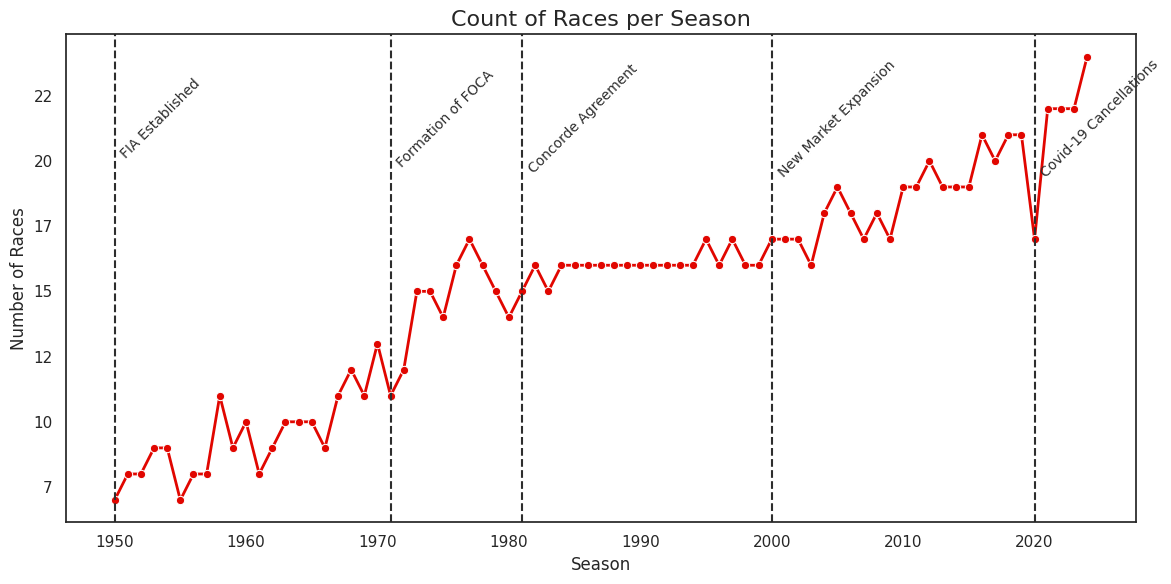

In [77]:
# Create the temporary dataframe
# note: as a convention any object that is specific to a given plot e.g., a temporary dataframe is denoted with plt_ prefix
plt_df = races.groupby(['year']).agg(race_count=('raceId', 'count')).reset_index()

# Set theme and figsize
sns.set_theme(style="white")
plt.figure(figsize=(12, 6))

line_plot = sns.lineplot(data=plt_df, x='year', y='race_count', marker='o', linewidth=2,color=f1_color_palette['F1 Red'])

#Clean up axis labels
plt.title("Count of Races per Season", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Number of Races", fontsize=12)

#flag some relevant events from wikipeida: https://en.wikipedia.org/wiki/Formula_One
key_events = {
    1950: "FIA Established",
    1971: "Formation of FOCA",
    1981: "Concorde Agreement",
    2000: "New Market Expansion",
    2020: "Covid-19 Cancellations"
}

for year, event in key_events.items():
    plt.axvline(x=year, color=f1_color_palette["Charcoal Gray"], linestyle='--', linewidth=1.5)
    plt.text(
        x=year + 0.3,  # offset so it doesn't overlap with the line
        y=plt_df['race_count'].max() * 0.9,  # position high on the y-axis
        s=event,
        rotation=45,
        verticalalignment='center',
        fontsize=10,
        color=f1_color_palette["Charcoal Gray"]
    )

# Set integer formatter for y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.tight_layout()
plt.show()

## New Circuit Count per Season

This view shows that expansion has been cautious and incremental. Even prior to the greater governance established in the 1980s (see above). Formula 1 never introduced more than three circuits during a season. In the modern era of Formula 1, new circuits are somewhat sparse and never exceed more than two races during a season, even as the total number of circuits climbs.

The viz below attempts to explain the same concept as above using stacked bar charts rather than dual axis charts. This approach is arguably more effective because it communicates both concepts without requiring a second axis. In addition, this approach provides a greater intuition of proportion.

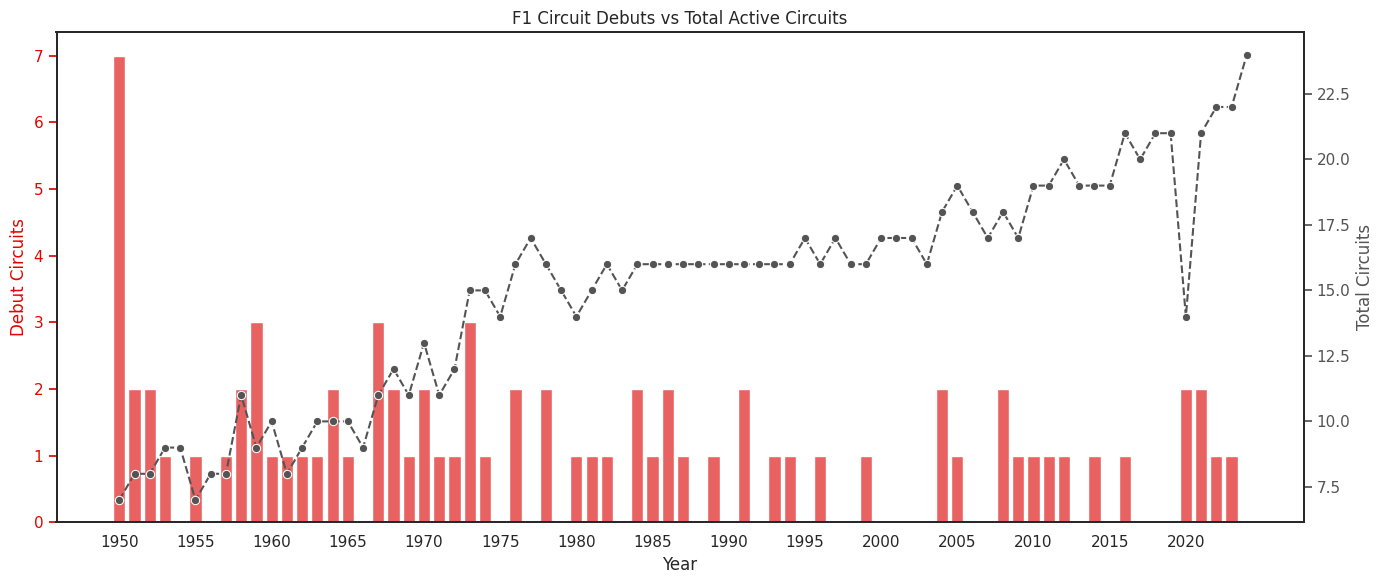

In [78]:
#create our total circuit count by year as df1
plt_df1 = races.groupby(['year']).agg(circuit_count = ('circuitId', 'nunique')).reset_index()
#identify new circuit debuts by finding the min year per circuit then aggregating by year
plt_df2=races.groupby(['circuitId']).agg(min_year = ('year', 'min')).reset_index()\
  .groupby(['min_year']).agg(circuit_debut_count = ('circuitId', 'count')).reset_index()

plt_df1 = plt_df1.merge(plt_df2, how = 'left', left_on = 'year',right_on='min_year')\
  .assign(year = lambda x: x.year.astype(str))


# Step 2: Set up Seaborn theme and plot
sns.set_theme(style="white")
fig, ax1 = plt.subplots(figsize=(14, 6))

# Step 3: Bar chart for circuit debuts (left axis)
sns.barplot(
    data=plt_df1,
    x='year',
    y='circuit_debut_count',
    color=f1_color_palette["Soft Red"],
    ax=ax1
)
ax1.set_ylabel("Debut Circuits", color=f1_color_palette["F1 Red"])
ax1.tick_params(axis='y', colors=f1_color_palette["F1 Red"])
ax1.set_xlabel("Year")

# Step 4: Line plot for total circuits (right axis)
ax2 = ax1.twinx()
sns.lineplot(
    data=plt_df1,
    x='year',
    y='circuit_count',
    color=f1_color_palette["Track Asphalt"],
    linestyle='--',
    marker='o',
    ax=ax2
)
ax2.set_ylabel("Total Circuits", color=f1_color_palette["Track Asphalt"])
ax2.tick_params(axis='y', colors=f1_color_palette["Track Asphalt"])

# Step 5: Final formatting
plt.title("F1 Circuit Debuts vs Total Active Circuits")
plt.xticks(rotation=45)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5)) #label every 5th year to reduce clutter
plt.tight_layout()
plt.show()

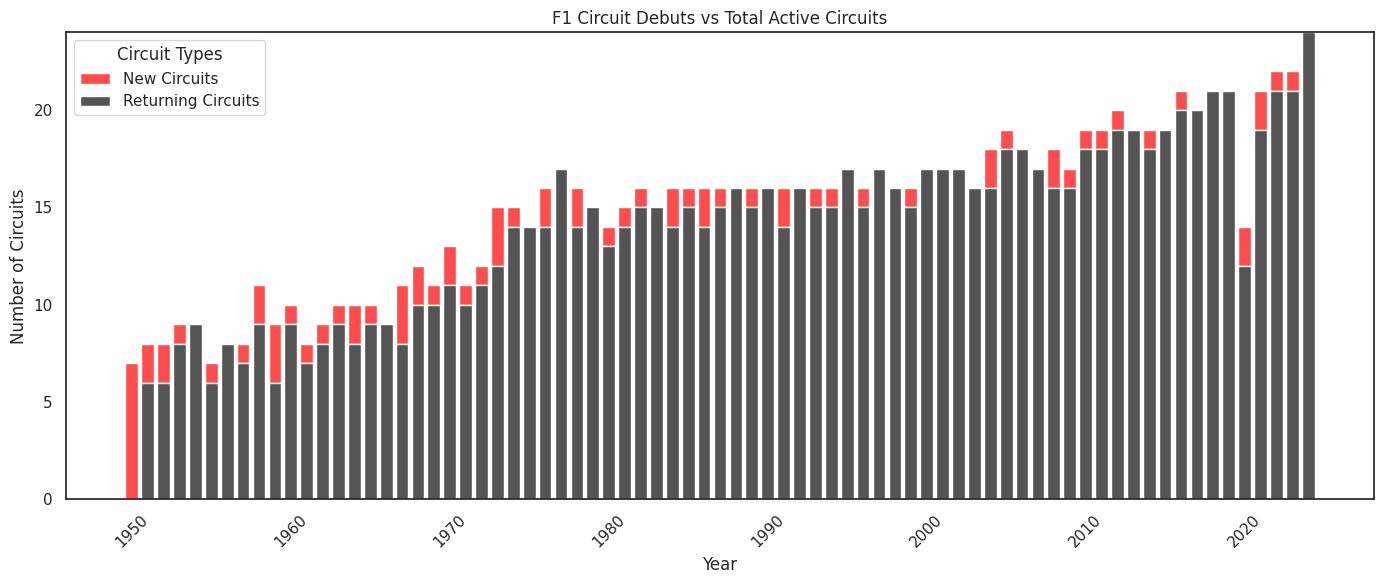

In [79]:
# as a follow up, I thought it would be valuable to visualize the proportion of new circuits over time

#create our total circuit count by year as df1
plt_df1 = races.groupby(['year']).agg(circuit_count = ('circuitId', 'nunique')).reset_index()
#identify new circuit debuts by finding the min year per circuit then aggregating by year
plt_df2=races.groupby(['circuitId']).agg(min_year = ('year', 'min')).reset_index()\
  .groupby(['min_year']).agg(circuit_debut_count = ('circuitId', 'count')).reset_index()
# merge and add a new column
plt_df = plt_df1.merge(plt_df2, how = 'left', left_on = 'year',right_on='min_year')
plt_df = plt_df.fillna(0)\
  .assign(returning_circuits = lambda x: x.circuit_count - x.circuit_debut_count.fillna(0))

colors = {
    'New Circuits': f1_color_palette["Soft Red"],
    'Returning Circuits': f1_color_palette["Track Asphalt"]
}


# Plot stacked bars
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(plt_df['year'], plt_df['circuit_debut_count'], bottom=plt_df['returning_circuits'],
       label='New Circuits', color=colors['New Circuits'])
ax.bar(plt_df['year'], plt_df['returning_circuits'], label='Returning Circuits', color=colors['Returning Circuits'])


#Formatting steps
ax.set_title('F1 Circuit Debuts vs Total Active Circuits')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Circuits')
ax.legend(title='Circuit Types', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Longest Running Cricuits
To further explore the history of the sport. The following visual displays the circuits that have hosted the greatest number of races. To provide additional context, I've highlighted the bars representing the circuits that are currently on the modern calendar.

This analysis shows that most used tracks are in Italy, Monaco, England and Belgium. One noteworthy insight is that both of the most visited legacy tracks (i.e., no longer on the calendar) are based in Germany (i.e., the Nurmburgring and Hockenheim). These omissions from the modern calendar in favor of non European circuits suggests an effort to diversify the and expand the fanbase.

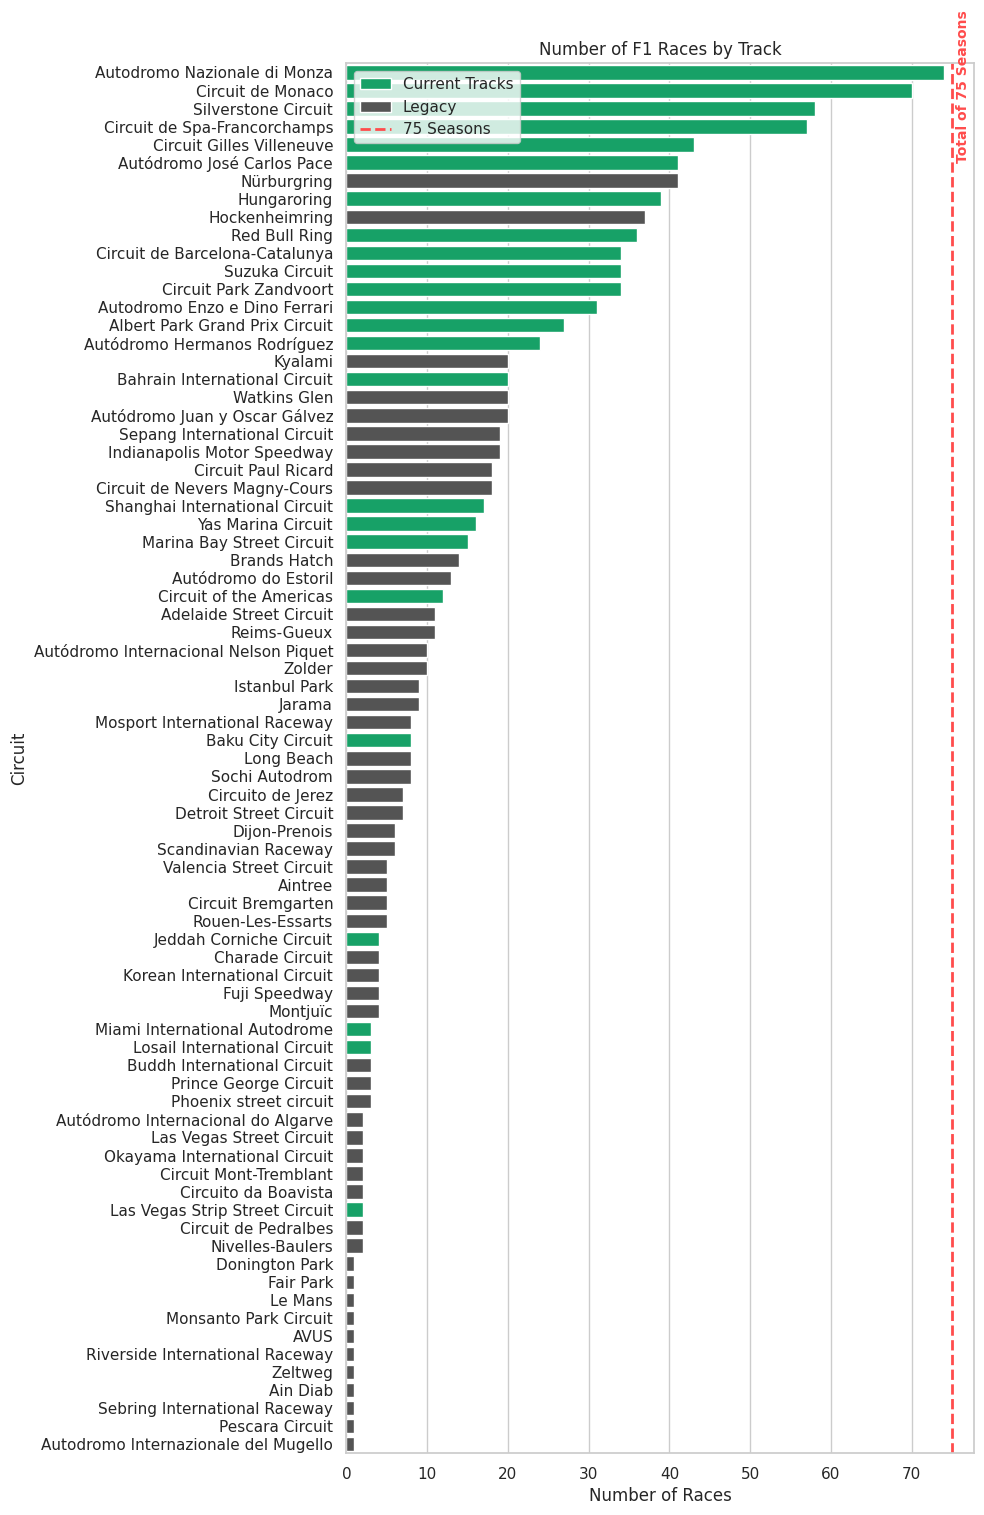

In [88]:
#prep a n of races by track
races_by_track = races.merge(circuits, how = 'left', on = 'circuitId',suffixes=['_race','_circuit'])\
  .groupby(['circuitId','name_circuit']).agg(race_count = ('year','nunique'))\
  .reset_index().sort_values('race_count',ascending=False)\
  .assign(label = lambda x: x.name_circuit)

#store the top 4 tracks for use later as benchmarks
top4 = races_by_track.head(4)['label'].to_list()

# Create a color column based on whether the track is in the top 4
plt_df = races_by_track.assign(color_category = lambda x: np.where(x.label.isin(current_tracks), 'Current Tracks', 'Legacy'))

# Define a palette for the barplot
color_palette = {
    'Current Tracks': f1_color_palette["DRS Green"],
    'Legacy': f1_color_palette["Track Asphalt"]
}


#visualize the n of races by track with a line showing the n of seasons
n_seasons = races.year.nunique()

plt.figure(figsize=(10, 15))
sns.barplot(data=plt_df, y='label', x='race_count', hue='color_category', palette=color_palette, dodge=False)

plt.title('Number of F1 Races by Track')
plt.xlabel('Number of Races')
plt.ylabel('Circuit')
plt.tight_layout()

plt.axvline(
    x=n_seasons,
    color=f1_color_palette["Soft Red"],
    linestyle='--',
    linewidth=2,
    label=f'{n_seasons} Seasons'
)

# Text label
plt.text(
    x=n_seasons + 0.5,  # slight offset to right
    y=5,                # vertical position (adjust for placement)
    s=f'Total of {n_seasons} Seasons',
    color=f1_color_palette["Soft Red"],
    rotation=90,
    va='bottom',
    ha='left',
    fontsize=10,
    fontweight='bold'
)
plt.legend(
    loc='upper left',
    bbox_to_anchor=(0, 1),
    frameon=True
)
plt.show()

## Team Count per Season
Unlike race count, constructor count gradually declined to the current 10-team format. This may suggest a progressive consolidation to the minimum level of competition required to sustain the sport. Stated differently, at any given moment in F1 history, the current constructor group has a vested interest in preventing dilution of revenue generated by the sport. However, further consolidation beyond a 10 team minimum would likely harm the entertainment value by diminshing competition. This hypothesis suggests that 10 is a lower limit or carrying capacity that modern F1 governance structure progresses to but cannot excede.

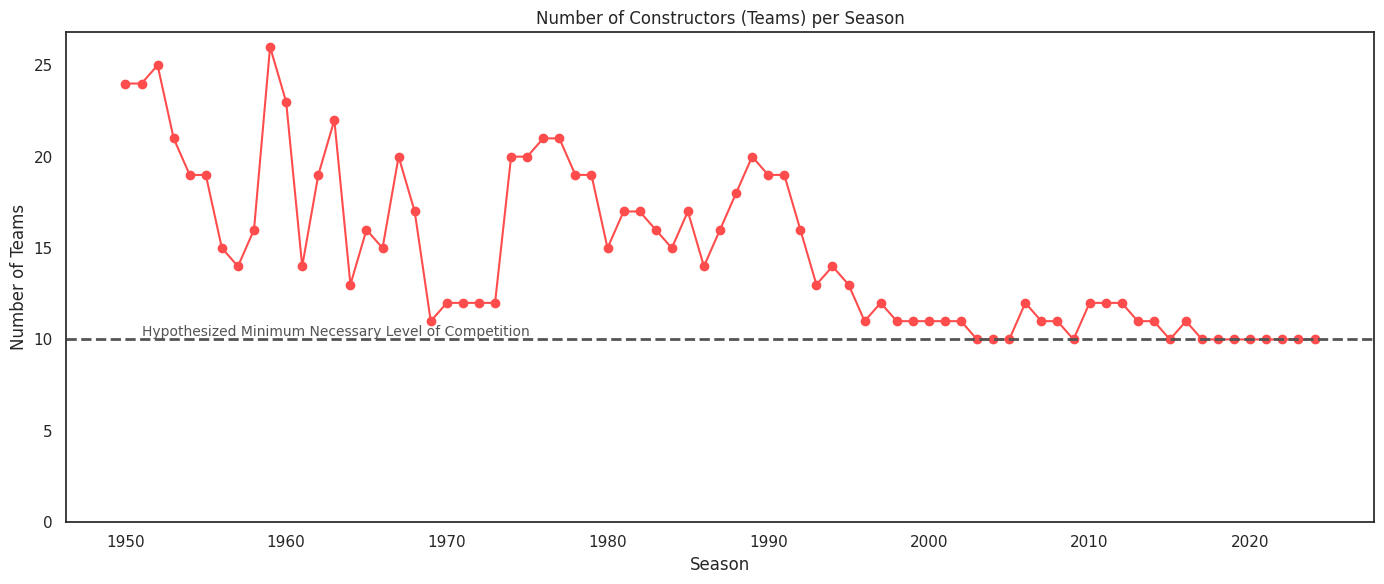

In [81]:
plt_df = combined_results_df.groupby(['year']).agg(
    team_count = ('constructorId', 'nunique')
  ).reset_index()


#specify colors for consistency
team_line_color = f1_color_palette["Soft Red"]  # dark gray/black
reference_line_color = f1_color_palette["Track Asphalt"]  # for annotation

#plot
fig, ax = plt.subplots(figsize=(14, 6))  # approx. 1000px wide

ax.plot(plt_df['year'], plt_df['team_count'], marker='o', color=team_line_color)
ax.set_title('Number of Constructors (Teams) per Season')
ax.set_xlabel('Season')
ax.set_ylabel('Number of Teams')
ax.set_ylim(bottom=0)  # Force y-axis to start at 0

# Reference line at y=10
ax.axhline(y=10, linestyle='--', linewidth=2, color=reference_line_color)
ax.text(plt_df['year'].min() + 1, 10.2,  # Adjust placement
        'Hypothesized Minimum Necessary Level of Competition',
        fontsize=10, color=reference_line_color)

plt.tight_layout()
plt.show()


## Fastest Lap Times by Season

This section attempts to track the fastest lap time through history. However, one significant unanticipated limitation of the data set is that fastest lap time is only available from 1995 forward. In addition, significant outliers (e.g., incelement weather) impact the trend.

The first visual displays the lap times by season for the four most historical tracks. Inflections in trend correspond with key regulation changes during this period. For example, cost cutting and safety efforts in the early 2000's ended a multi year trend of faster laptimes https://en.wikipedia.org/wiki/History_of_Formula_One_regulations.

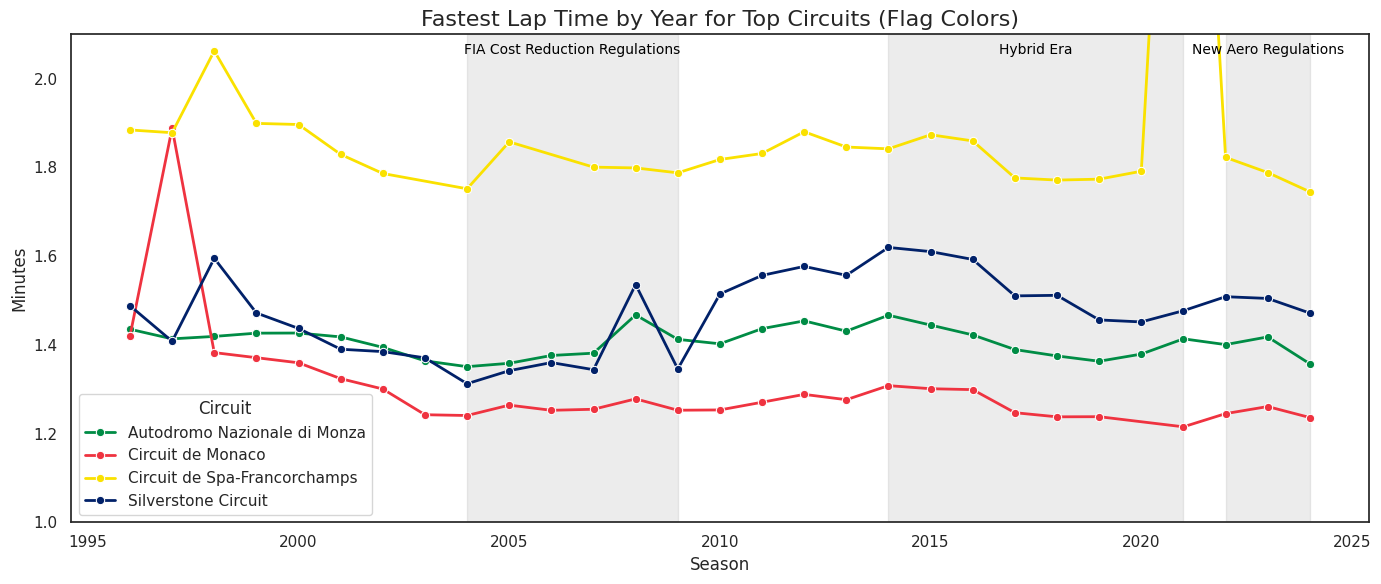

In [99]:
flag_colors = {
    'Silverstone Circuit': '#012169',      # UK (navy blue)
    'Autodromo Nazionale di Monza': '#008C45',                    # Italy (green)
    'Circuit de Monaco': '#EF3340',        # Monaco (red)
    'Circuit de Spa-Francorchamps': '#FAE100',        # Belgium (yellow)
}
plt_df = agg_race_lap_times_df.query('name in @top4').assign(
    fastest_lap_minutes=lambda x: x.fastest_lap_ms / 60000
)

# Set theme
sns.set_theme(style="white")

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=plt_df,
    x='year',
    y='fastest_lap_minutes',
    hue='name',
    palette=flag_colors,
    marker='o',
    linewidth=2
)

# Format axes
plt.title("Fastest Lap Time by Year for Top Circuits (Flag Colors)", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Minutes", fontsize=12)
plt.legend(title="Circuit")
plt.tight_layout()

#highilight key periods for the viewer https://en.wikipedia.org/wiki/History_of_Formula_One_regulations

highlight_periods = [
    (2004,2009, 'FIA Cost Reduction Regulations'),
    (2014, 2021, 'Hybrid Era'),    # e.g., new engine rules
    (2022, 2024, 'New Aero Regulations')  # e.g., ground effect reintroduction
]

# Highlight background regions
for start, end, label in highlight_periods:
    plt.axvspan(start, end, color='gray', alpha=0.15)
    plt.text((start + end) / 2, 2.05, label, color='black', ha='center', va='bottom', fontsize=10)


plt.ylim(1.0, 2.1)  # limiting the y axis to eliminate the outlier effect of spa in 2020 (rain year)
plt.show()

## Heatmap Variance to Fastest Lap of All Time by Season
This heatmap displays the variance in fastest lap times by year relative to the fastest lap ever recorded at each track. The analysis is limited to circuits that have hosted at least 15 races since our earliest data in 1995. This approach was an attempt to expand on the trend plot above by allowing for more circuits (one key limitation of line charts).

One unintended outcome of this approach is that it highlights changes in track layout that dramatically affect minimum lap times—and therefore the colorscale of the plot.

For example, the redesign of Hockenheim (https://en.wikipedia.org/wiki/Hockenheimring) is clearly visible, with noticeable changes in lap times beginning in 2002.

The most dramatic example is Bahrain in 2020, when the circuit was reconfigured to host a second race after earlier events were canceled due to the pandemic. This one-time layout resulted in significantly faster lap times, which heavily influence the variance calculation.

These outlier events affect the color scaling in a way that makes gradual trends less visible. As such, this method is more effective at highlighting major changes at individual tracks rather than capturing broader shifts driven by sporting regulations.



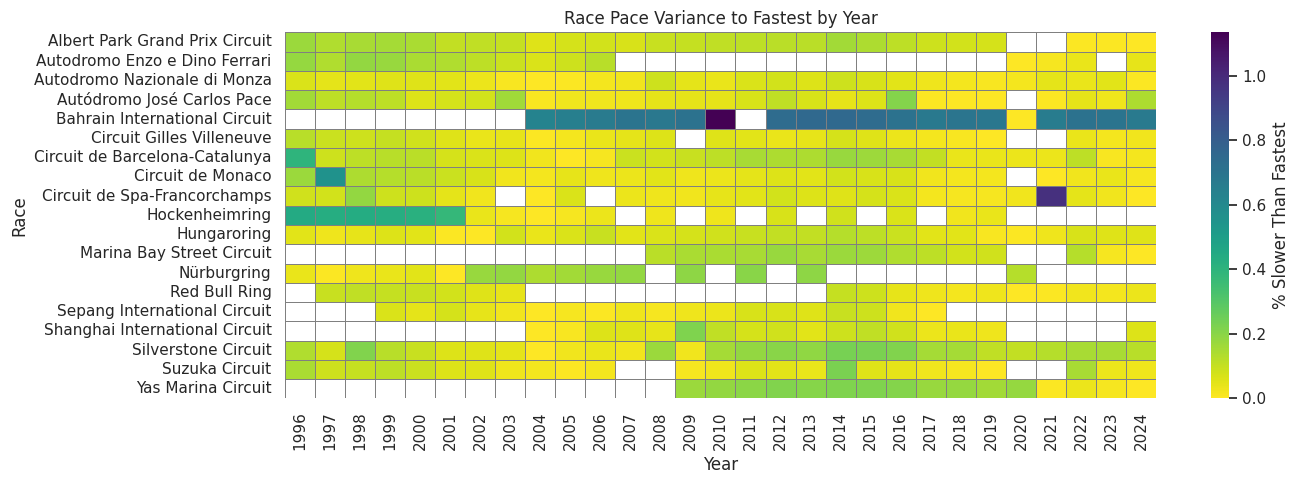

In [123]:
# find all of the tracks that
fastest_all_time = agg_race_lap_times_df.groupby('name').agg(
    n_seasons = ('year','nunique'),
    fastest_lap_all_time = ('fastest_lap_ms','min'),
).reset_index().query('n_seasons >= 15')


plt_df = agg_race_lap_times_df.merge(fastest_all_time)\
  .assign(pct_variance_to_fastest = lambda x: x.fastest_lap_ms /x.fastest_lap_all_time-1)

plt_piv = plt_df.pivot(index='name', columns='year', values='pct_variance_to_fastest')

# Create heatmap
plt.figure(figsize=(14, 5))
sns.heatmap(
    plt_piv,
    cmap="viridis_r",        # viridis is the goat
    annot=False,
    fmt=".1f",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': '% Slower Than Fastest'}
)

plt.title("Race Pace Variance to Fastest by Year")
plt.xlabel("Year")
plt.ylabel("Circuit")
plt.tight_layout()
plt.show()




# Constructors & Drivers: Historical Performance
- Wins by Constructor Over Time
- Most Successful Drivers by Wins/Podiums/Poles vs Teammate

# Qualifying vs Finish Dynamics
-  Grid Position vs Finishing Position: To what extent does the qualifying result determine the race result?
- Track Dynamics: Which tracks are most determined by qualifying?
- Driver Dynamics: Which drivers are most capable of improving their results on race day?

# Summary Findings & Executive Summary
 - Key insights
 - Limitations & Areas of Future Analysis
 - Alternative Visualization Techniques

## Limitations & Areas of Future Analysis

- Source data set did not include any contextual or financial information (e.g., worldwide viewership or revenue). This data is necessary to understand the economic forces that influence the history of Formula 1. Future areas of analysis should explore these topics in conjunction with the analysis above.

## Alternative Visuals

## Alt Time Series Options
Ultimately a line chart was chosen for most time series visualizations due to simplicity and clarity. Other options such as bar chart and area chart were considered (see below):

 - Clear alignment of annotations with exact years, making it easier to associate key governance events with specific inflection points in performance.

 - Better readability over long time spans, especially when data spans multiple decades with relatively small year-over-year changes.

 - Reduced visual clutter, since area and bar charts can obscure baseline values or crowd the horizontal axis when combined with multiple annotation layers.

 - Interactive packages like altair and plotly were initially used but abandoned because they do not render in github.

In [84]:
plt_df = combined_results_df.groupby(['year']).agg(
    team_count = ('constructorId', 'nunique')
  ).reset_index()

fig = px.bar(plt_df,x='year',y='team_count', title = 'Number of Constructors (Teams) per Season',
              height =500,width=1000,template='seaborn')
#clean up the axis labels
fig.update_layout(xaxis_title = 'Season', yaxis_title = 'Number of Races')
fig.show()

In [85]:
plt_df = combined_results_df.groupby(['year']).agg(
    team_count = ('constructorId', 'nunique')
  ).reset_index()

fig = px.area(plt_df,x='year',y='team_count', title = 'Number of Constructors (Teams) per Season',
              height =500,width=1000,template='seaborn')
#clean up the axis labels
fig.update_layout(xaxis_title = 'Season', yaxis_title = 'Number of Races')
fig.show()

In [86]:
#note: for this project I use plt_df as a temporary dataframe that is specific to the cell in which it was run
#this convention allows vis-specific manipulation without impacting broad use dataframes
plt_df = races.groupby(['year']).agg(race_count = ('raceId', 'count')).reset_index()
fig = px.line(plt_df, x = 'year', y = 'race_count', title = 'Number of Races per Season',markers='.',
              height =500,width=1000,template='seaborn')
#clean up the axis labels
fig.update_layout(xaxis_title = 'Season', yaxis_title = 'Number of Races')

#flag some relevant events from wikipeida: https://en.wikipedia.org/wiki/Formula_One

key_events = {
    1950: "FIA Established",
    1971: "Formation of FOCA",
    1981: "Concorde Agreement: Governance",
    2000: "Effort to Expand to New Markets",
    2020: "Races Canceled Due to Covid 19"
}
for year, event in key_events.items():
    fig.add_vline(
        x=year,
        annotation_text = event,
        opacity=1,
        annotation_textangle=45,
        line_width=2,
        line_dash="dash",
        line_color="grey",
    )

fig.show()

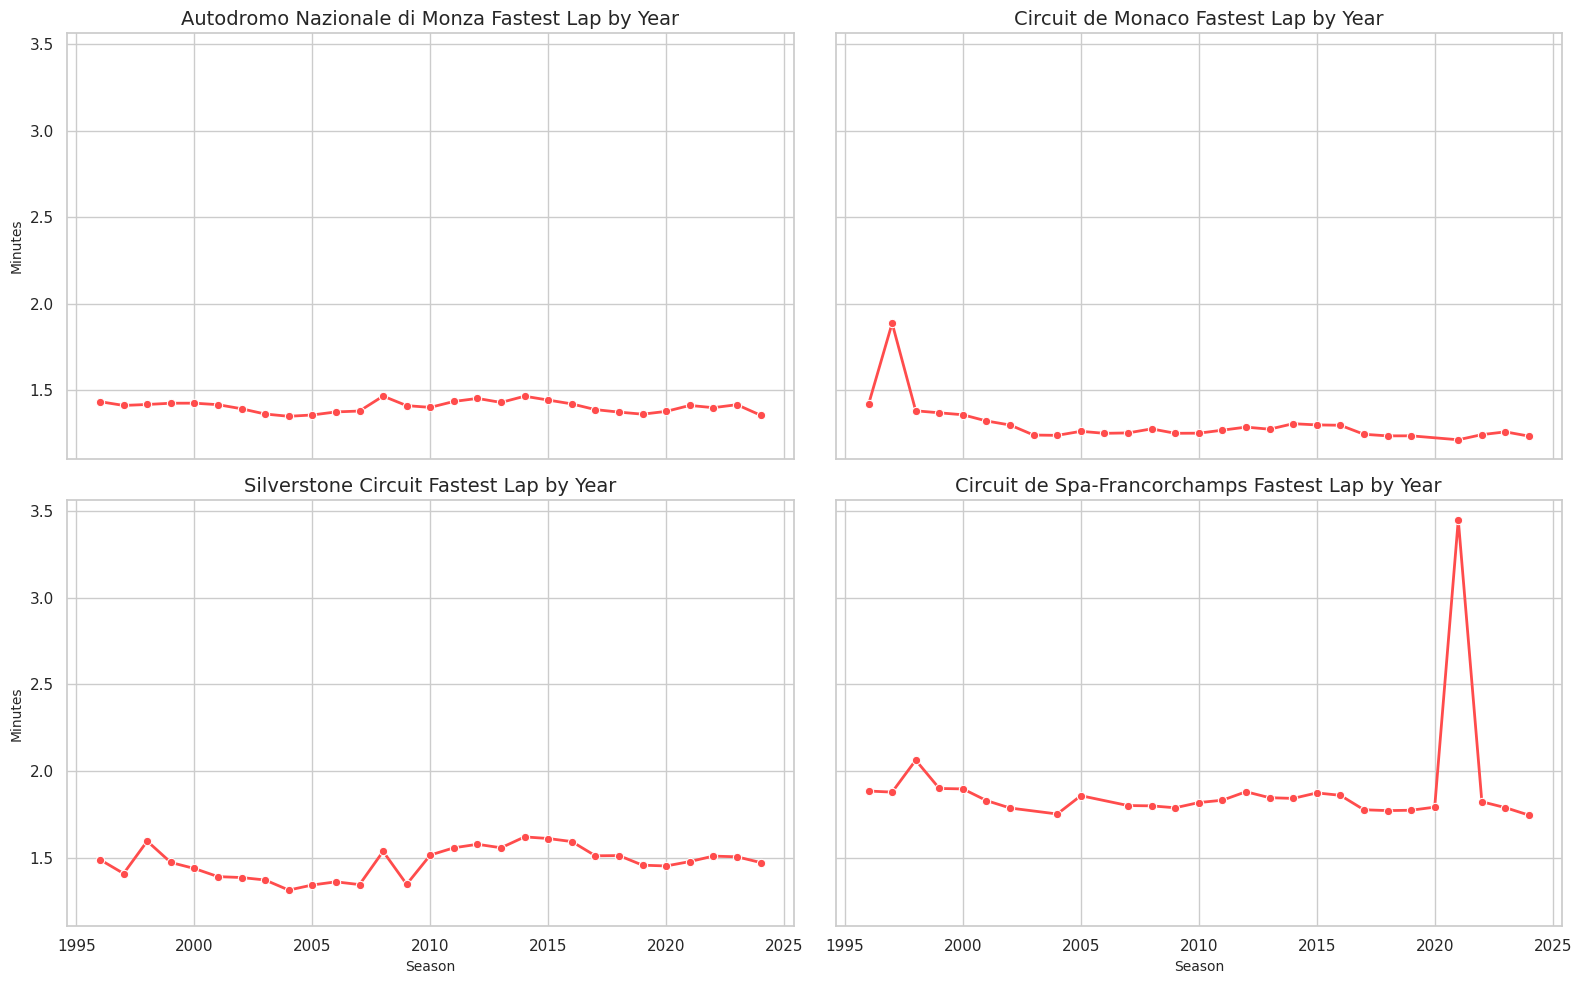

In [87]:

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten 2x2 array to 1D for easy indexing

for i, c in enumerate(top4):
    plt_df = agg_race_lap_times_df.query('name == @c').assign(
        fastest_lap_minutes=lambda x: x.fastest_lap_ms / 60000
    )

    sns.lineplot(
        data=plt_df,
        x='year',
        y='fastest_lap_minutes',
        marker='o',
        linewidth=2,
        color=f1_color_palette['Soft Red'],
        ax=axes[i]
    )

    axes[i].set_title(f"{c} Fastest Lap by Year", fontsize=14)
    axes[i].set_xlabel("Season", fontsize=10)
    axes[i].set_ylabel("Minutes", fontsize=10)

# Tidy layout
plt.tight_layout()
plt.show()
